In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [33]:
# packages
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import time

# 1. Pubtator API (TODO-Partially done)
- using the input folder, check if the file(s) have been pre-annotated by checking if the following APIs return something
```
https://www.ncbi.nlm.nih.gov/research/pubtator3-api/publications/export/biocxml?pmids={id}
or
https://www.ncbi.nlm.nih.gov/research/pubtator3-api/publications/pmc_export/biocxml?pmcids=PMC{id}
```
  - if annotated, retrieve it and put it in the output folder
  - if not, use the [example code](https://www.ncbi.nlm.nih.gov/CBBresearch/Lu/Demo/tmTools/download/ExampleCode.Python.zip) they provide to send it to the server to be annotated (Done)

Using colab:

```
mkdir input
```

to make a input folder

In [ ]:
!bash

In [ ]:
# SubmitText_request.py
!pip install unidecode

import requests
import os
import sys
from unidecode import unidecode
import unicodedata
import re

def submit_text_request(input_folder, bioconcept, output_file_session_number):
    pattern = r'[^0-9a-zA-Z\!\@\#\$\%\^\&\*\(\)\_\+\{\}\|\:\"\<\>\?\-\=\[\]\\;\'\,\.\/ \t\n\r]'
    unicode_to_regular = {}
    with open('lib/unicode.txt', 'r', encoding='utf-8') as input_file:
        for line in input_file:
            line = line.strip()
            parts = line.split("\t")
            if len(parts) == 2:
                uni, reg = parts
                if reg == '-whitespace-':
                    unicode_to_regular[uni] = ' '
                else:
                    unicode_to_regular[uni] = reg

    with open(output_file_session_number, 'w', encoding='utf-8') as output_file:
        for filename in os.listdir(input_folder):
            if filename.startswith('.'):
                continue  # Skip hidden files
            text_str = ''
            with open(os.path.join(input_folder, filename), 'r', encoding='utf-8') as file_input:
                for line in file_input:
                    normalized_line = unicodedata.normalize('NFC', line)
                    for uni, reg in unicode_to_regular.items():
                        normalized_line = normalized_line.replace(uni, reg)
                    normalized_line = unidecode(normalized_line)  # Assuming unidecode does similar work to Perl's version
                    text_str += normalized_line
            text_str = re.sub(pattern, ' ', text_str)
            url = "https://www.ncbi.nlm.nih.gov/CBBresearch/Lu/Demo/RESTful/request.cgi"
            response = requests.post(url, data={'text': text_str, 'bioconcept': bioconcept})

            if response.status_code == 200:
                session_number = response.json().get('id', '')
                print(f"Thanks for your submission. The session number is: {session_number}")
                output_file.write(f"{session_number}\t{filename}\n")
            else:
                print(f"Error: HTTP {response.status_code} for {filename}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


UnboundLocalError: local variable 'child' referenced before assignment

--- Logging error ---
Traceback (most recent call last):
  File "/Users/crystalcho/.pyenv/versions/3.10.6/lib/python3.10/site-packages/IPython/utils/_process_posix.py", line 151, in system
    child = pexpect.spawn(self.sh, args=['-c', cmd])  # Vanilla Pexpect
  File "/Users/crystalcho/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pexpect/pty_spawn.py", line 205, in __init__
    self._spawn(command, args, preexec_fn, dimensions)
  File "/Users/crystalcho/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pexpect/pty_spawn.py", line 303, in _spawn
    self.ptyproc = self._spawnpty(self.args, env=self.env,
  File "/Users/crystalcho/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pexpect/pty_spawn.py", line 315, in _spawnpty
    return ptyprocess.PtyProcess.spawn(args, **kwargs)
  File "/Users/crystalcho/.pyenv/versions/3.10.6/lib/python3.10/site-packages/ptyprocess/ptyprocess.py", line 289, in spawn
    os.execv(command, argv)
  File "/Users/crystalcho/.pyenv/versions/3.10.6/l

In [38]:
# SubmitText_retreive.py
import requests
import os
import sys

def submit_text_retrieve(input_folder, inputfile_session_number, output_folder):
    # Ensure output directory exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    sn_hash = {}
    with open(inputfile_session_number, 'r') as input_file:
        for line in input_file:
            line = line.strip()
            if line:
                session_number, input_filename = line.split("\t")
                sn_hash[session_number] = input_filename

    base_url = "https://www.ncbi.nlm.nih.gov/CBBresearch/Lu/Demo/RESTful/retrieve.cgi"

    for session_number, input_filename in sn_hash.items():
        output_file_path = os.path.join(output_folder, input_filename)
        if os.path.exists(output_file_path):
            print(f"{output_file_path} - finished")
            continue

        retrieve_url = f"{base_url}?id={session_number}"
        response = requests.get(retrieve_url)
        if response.status_code == 200:
            with open(output_file_path, 'w', encoding='utf-8') as output_file:
                output_file.write(response.text)
            print(f"{session_number} : Result is retrieved.")
        else:
            print(f"{session_number} : Error retrieving results - {response.status_code}")


In [61]:
input_folder = "input"       # pull xml,json, or pubtator formatted files here to be annotated
bioconcept = "Gene"                                         # we only want the genes
output_file_session_number = "Session_Number.txt"  # output file for session number which will be used to retrieve the results
submit_text_request(input_folder, bioconcept, output_file_session_number)    # submit the text for annotation

Thanks for your submission. The session number is: 0C75BFC8CBEEEC29AFF0
Thanks for your submission. The session number is: A95E896E53DA4E110CBF


## Running the code below takes time, so it might say error 400. Just rerun it a bit later.

In [75]:
input_folder = "input"
inputfile_session_number = "Session_Number.txt"
output_folder = "output"
submit_text_retrieve(input_folder, inputfile_session_number, output_folder)


0C75BFC8CBEEEC29AFF0 : Error retrieving results - 400
A95E896E53DA4E110CBF : Error retrieving results - 400


# 2. Relevance (Done)
- This can be integrated with Gene Chunking. We can just check if the paper has genes (i.e check if there is an item in the dictionary @ line 171)

*3. Gene Chunking*
=============
Given a **preannotated** article (check input folder) analyze the **XML** file via `parse_xml_file(xml_file_path)` which returns a dictionary of "Gene Class" from that file  

The Gene Class has the following information:
- self.gene_id: the gene id (from the xml file)
- self.occurences: A list of occurences of the gene in the text. Each occurence is **3-sentences long**.
    - The second sentence contains the explicit mention of the gene.
    - The first and third sentences are the context of the gene mention.
- self.symbol: the gene symbol (from NCBI. Initialized to None)
- self.organism: the organism of the gene (from NCBI. Initialized to None)
- self.full_name: the full name of the gene (from NCBI. Initialized to None. Set to name_from_article if not found in NCBI)
- self.also_known_as: a list of other names of the gene (from NCBI. Initialized to None. Set to name_from_article if not found in NCBI)
- self.name_from_article: the name of the gene as found in the article

Steps:
1. define the class Gene
2. Parse the xml file
3. update the Gene class with the information from NCBI
Now you have a dictionary of Gene classes.~

TIPS:
- control + F "sentence_buffer" to find where you can adjust the buffer

In [141]:
!pip install biopython
import xml.etree.ElementTree as ET
from Bio import Entrez
import re
import time

class Gene:
    def __init__(self, gene_id):
        self.gene_id = gene_id
        self.occurrences = []  # list to store snippet(s) where the gene was mentioned
        self.symbol = None
        self.organism = None
        self.full_name = None
        self.also_known_as = None
        self.name_from_article = None
        self.doc_id = None

    def add_occurrence(self, snippet):
        if snippet not in self.occurrences:  # Avoid duplicates
            self.occurrences.append(snippet)

    def set_name_from_article(self, name_from_article):
        """Sets the temporary name of the gene. This is the name according to the article"""
        self.name_from_article = name_from_article

    def get_name_from_article(self):
        return self.name_from_article

    def get_occurrences(self):
        return self.occurrences

    def get_also_known_as(self):
        return self.also_known_as

    def get_gene_id(self):
        return self.gene_id
    
    def get_organsim(self):
        return self.organism
    
    def get_doc_id(self):
        return self.doc_id
    
    def set_doc_id(self, doc_id):
        self.doc_id = doc_id

    def update_info(self, symbol, organism, full_name, also_known_as):
        self.symbol = symbol
        self.organism = organism
        self.full_name = full_name
        self.also_known_as = also_known_as

    def __repr__(self):
        return (f"Gene({self.gene_id})\n"
                f"  Symbol          : {self.symbol}\n"
                f"  Organism        : {self.organism}\n"
                f"  Full Name       : {self.full_name}\n"
                f"  Also Known As   : {self.also_known_as}\n"
                f"  In-text Name    : {self.name_from_article}\n"
                f"  Occurrences     : {self.occurrences}\n"
                f"  Document ID     : {self.doc_id}")

def parse_xml_file(xml_path):
    """Parses the XML file and returns a gene dictionary keyed by gene ID."""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    gene_dict = {}

    for document in root.findall('document'):
        
        # get the document ID (pmid or pmcid)
        doc_id_elem = document.find('id')
        if doc_id_elem is not None:
            doc_id = doc_id_elem.text
        else:
            doc_id = None


        # get the gene annotations in the document from the passages
        for passage in document.findall('passage'):       
            # Also check for 'article-id_pmc'
            article_id_pmc_elem = passage.find("infon[@key='article-id_pmc']")
            if article_id_pmc_elem is not None:
                pmc_value = article_id_pmc_elem.text.strip()
                if not pmc_value.startswith("PMC"):
                    pmc_value = "PMC" + pmc_value
                doc_id = pmc_value     
            section_type_elem = passage.find("infon[@key='section_type']")
            if section_type_elem is not None and section_type_elem.text and section_type_elem.text.upper() in ("METHODS", "FIG", "TABLE"):
                continue  # Skip passages under METHODS
            # Get the full passage text.
            passage_text_elem = passage.find("text")
            passage_text = passage_text_elem.text if passage_text_elem is not None else ""
            # Determine the starting offset for this passage.
            passage_offset_elem = passage.find("offset")
            passage_offset = int(passage_offset_elem.text) if passage_offset_elem is not None else 0
            # Split the passage into sentences using regex.
            sentences = re.split(r'(?<=[.!?])\s+', passage_text)
            # Compute start indices for each sentence within the passage text.
            start_indices = []
            current_index = passage_offset
            for sentence in sentences:
                start_indices.append(current_index)
                current_index += len(sentence) + 1  # account for the delimiter space

            # Dictionary to store annotations per gene in this passage.
            # For each gene_id, we collect the sentence indices and a temporary in-text name.
            gene_annotations = {}
            for annotation in passage.findall('annotation'):
                ann_type = annotation.find("infon[@key='type']")
                if ann_type is not None and ann_type.text == "Gene":
                    # Check for both 'identifier' and 'NCBI Gene' keys.
                    gene_id_elem = annotation.find("infon[@key='identifier']")
                    if gene_id_elem is None:
                        gene_id_elem = annotation.find("infon[@key='NCBI Gene']")
                    gene_id = gene_id_elem.text if gene_id_elem is not None else None

                    # Handle multiple IDs by keeping only the first if needed.
                    if gene_id and ";" in gene_id:
                        gene_id = gene_id.split(";")[0].strip()

                    # Extract the gene name from the annotation text.
                    in_text_gene_name_elem = annotation.find("text")
                    in_text_gene_name = in_text_gene_name_elem.text if in_text_gene_name_elem is not None else None

                    # Extract the annotation location (offset) to find the sentence.
                    location_elem = annotation.find("location")
                    ann_offset = int(location_elem.attrib.get('offset', 0)) if location_elem is not None else 0

                    # Determine which sentence contains the annotation based on its offset.
                    sentence_index = None
                    for i, start in enumerate(start_indices):
                        if start <= ann_offset < start + len(sentences[i]):
                            sentence_index = i
                            break

                    if sentence_index is not None and gene_id:
                        if gene_id not in gene_annotations:
                            gene_annotations[gene_id] = {'indices': [], 'name': in_text_gene_name}
                        gene_annotations[gene_id]['indices'].append(sentence_index)

            # For each gene in this passage, process the annotation indices.
            for gene_id, data in gene_annotations.items():
                # Remove duplicate indices and sort.
                indices = sorted(set(data['indices']))
                candidate_windows = []
                # For each annotation occurrence, form a candidate window:
                # one sentence before and one sentence after the annotated sentence.
                for idx in indices:
                    start_sentence = max(0, idx - 1)
                    end_sentence = min(len(sentences), idx + 2)  # end index is non-inclusive
                    candidate_windows.append((start_sentence, end_sentence))
                # Merge overlapping candidate windows.
                merged_windows = []
                for window in sorted(candidate_windows):
                    if not merged_windows:
                        merged_windows.append(window)
                    else:
                        last = merged_windows[-1]
                        # If windows overlap or touch, merge them.
                        if window[0] <= last[1]:
                            merged_windows[-1] = (last[0], max(last[1], window[1]))
                        else:
                            merged_windows.append(window)
                # For each merged window, if it spans more than 3 sentences, split it into chunks of 3 sentences maximum.
                for window in merged_windows:
                    start, end = window
                    window_size = end - start
                    if window_size <= 3:
                        snippet = " ".join(sentences[start:end])
                        if gene_id in gene_dict:
                            gene_dict[gene_id].add_occurrence(snippet)
                        else:
                            gene_obj = Gene(gene_id)
                            gene_obj.add_occurrence(snippet)
                            gene_obj.set_doc_id(doc_id)
                            gene_obj.set_name_from_article(data['name'])
                            gene_dict[gene_id] = gene_obj
                    else:
                        # Split the merged window into non-overlapping chunks of at most 3 sentences.
                        for i in range(start, end, 3):
                            chunk_end = min(i + 3, end)
                            snippet = " ".join(sentences[i:chunk_end])
                            if snippet.strip():
                                if gene_id in gene_dict:
                                    gene_dict[gene_id].add_occurrence(snippet)
                                else:
                                    gene_obj = Gene(gene_id)
                                    gene_obj.set_doc_id(doc_id)
                                    gene_obj.add_occurrence(snippet)
                                    gene_obj.set_name_from_article(data['name'])
                                    gene_dict[gene_id] = gene_obj
    return gene_dict

def fetch_and_update_gene_info(gene_dict):
    """Retrieves gene information from NCBI and updates the genes in gene_dict."""
    gene_ids = list(gene_dict.keys())
    if gene_ids:
        # Post the gene IDs to NCBI.
        handle = Entrez.epost(db="gene", id=",".join(gene_ids))
        result = Entrez.read(handle)
        handle.close()

        webenv = result["WebEnv"]
        query_key = result["QueryKey"]

        handle = Entrez.esummary(db="gene", webenv=webenv, query_key=query_key)
        record = Entrez.read(handle)
        handle.close()

        for docsum in record["DocumentSummarySet"]["DocumentSummary"]:
            gene_id = docsum.attributes["uid"]
            symbol = docsum.get('NomenclatureSymbol', 'No symbol')
            organism = docsum.get('Organism', {}).get('ScientificName', 'No organism')
            full_name = docsum.get('NomenclatureName', gene_dict[gene_id].get_name_from_article())
            also_known_as = docsum.get('OtherAliases', gene_dict[gene_id].get_name_from_article())

            if full_name == '':
                full_name = gene_dict[gene_id].get_name_from_article()
            if also_known_as == '':
                also_known_as = gene_dict[gene_id].get_name_from_article()

            if gene_id in gene_dict:
                gene_dict[gene_id].update_info(symbol, organism, full_name, also_known_as)
            time.sleep(0.5)  # Pause briefly to avoid overwhelming NCBI servers.

# Set your email (and API key if available)
Entrez.email = "email here"
# Entrez.api_key = "your_api_key"

xml_path = "./output/PMC6484421.xml"
gene_dict = parse_xml_file(xml_path)
fetch_and_update_gene_info(gene_dict)  # Optionally fetch gene info from NCBI

print("There are {} genes in the paper.".format(len(gene_dict)))
if len(gene_dict) == 0:
    print("No genes found in the paper.")
else:
    for gene in gene_dict.values():
        print(gene)
        print(f"There are {len(gene.get_occurrences())} occurrence(s) (each occurrence is at most 3 sentences long) for gene {gene.get_gene_id()} : {gene.get_name_from_article()}.")
        print("")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
120119.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
There are 31 genes in the paper.
Gene(7049)
  Symbol          : TGFBR3
  Organism        : Homo sapiens
  Full Name       : transforming growth factor beta receptor 3
  Also Known As   : BGCAN, betaglycan
  In-text Name    : TGFBR3
  Occurrences     : ['Novel role of the clustered miR-23b-3p and miR-27b-3p in enhanced expression of fibrosis-associated genes by targeting TGFBR3 in atrial fibroblasts', "Overexpression of miR-23b-3p and miR-27b-3p enhanced the expression of collagen, type I, alpha 1 (COL1A1), COL3A1 and ACTA2 in HAFs without significant effects on their proliferation and migration. Luciferase assay showed that miR-23b-3p and miR-27b-3p targeted two different sites in 3'-UTR of transforming growth factor (TGF)-beta1 receptor 3 (TGFBR3) respectively. Consistently, TGFBR3 siRNA could increase fibrosis-related genes expression, along with the Smad1 inactivation and Sm

# 3.5 Prompt Engineering
- Creates the prompt using the Gene dictionary (from Gene chunking)
- batch_size: allows you to have more than 1 Gene in the prompt such that you have something like the following. Ideally keep it at batch_size=1 to ensure that the GO terms generated are exclusive to the Gene being analyzed.

```
# batch_size > 1 has the basic format:
Basic Prompt
Gene 1
Gene 2
...
# batch_size = 1 has the basic format:
Basic Prompt
Gene 1
```
- batch_index: allows you to iterate through the gene dictionary so that if you have a paper with x amount of genes, you can just increment  the index and run the inference x amount of times.
- direct: ignore this. This is for the future.
- customized_prompt: ignore this as well. This is for the future.

In [142]:
def make_go_term_prompt(gene_dict, batch_size=1, batch_index=0, direct=False, customized_prompt=None):
    """
    Create a prompt for Llama to output Gene Ontology (GO) terms (without IDs) for a batch of genes
    from the gene dictionary. The output is expected to be categorized into three sections for each gene:
      1. Biological Processes
      2. Cellular Components
      3. Molecular Functions

    For each gene, the output should follow the format below without mixing results across different genes.

    :param gene_dict: A dictionary where each key is a gene ID and each value is a Gene object that
                      contains attributes such as symbol, organism, full_name, and occurrences.
    :param batch_size: The number of genes to include in this prompt batch.
    :param batch_index: The index (0-based) of the batch to process. For instance, if batch_size=1,
                        batch_index=2 will include the 3rd gene in the dictionary.
    :param direct: If True, use a more direct instruction for GO term extraction.
    :param customized_prompt: If provided, use this custom prompt text in place of the default.
    :return: A string containing the complete prompt.
    """

    # Instruction blocks

    # context = """You are an efficient and insightful assistant to a geneticist."""

    general_instructions = """Analyze the following gene information and text snippets under "Occurrences".
Identify all potentially relevant Gene Ontology (GO) terms using only evidence explicitly stated in the text.
Do not include any GO terms based on inferences or assumptions not explicitly supported by the text.

After completing your analysis, for each Gene Ontology (GO) term you list, provide a short one-line justification referencing the text as well as a relationship between the gene and the term.
If the text does not explicitly support a GO term (even if it might be inferred), do not include it. If no GO term is supported for a particular gene, say “None found.”

Be concise, do not use unnecessary words.
Be factual, do not editorialize.
Be specific, avoid overly general statements like "it is involved in many cellular processes".

"""

    example = """To help you in your work, I am providing an example of gene information and the corresponding example analysis output structured in JSON.

Example gene information is:
Gene: myogenin
Organism: Mus musculus
Occurrences:
- Activation of NF-kappaB increases the expression of the inducible nitric oxide synthase (iNOS) in muscle cells that sequester HuR (RNA-binding protein) by preventing transcription of MyoD. Denervation-induced atrophy is related to the upregulation of specific histone deacetylases (HDAC), able to repress a negative regulator of myogenin, with an increase in MuRF1 expression and muscle wasting. AMPK (protein kinase activated by 5'adenosine monophosphate) is also involved in muscle atrophy.

Example anaylysis output is:
[
  {
    "gene": "myogenin",
    "go_data": [
      {
        "term": "DNA-binding transcription activator activity",
        "relationship": "enables",
        "namespace": "molecular_function",
        "justification": "Myogenin is a key transcription factor in muscle differentiation that binds to E-box sequences in muscle-specific genes and activates their transcription through RNA polymerase II."
      },
      {
        "term": "skeletal muscle cell differentiation",
        "relationship": "involved_in",
        "namespace": "biological_process",
        "justification": "Myogenin is one of the four myogenic regulatory factors (MRFs) that drive skeletal muscle differentiation by promoting the transition from myoblasts to myotubes."
      },
      {
        "term": "nucleus",
        "relationship": "located_in",
        "namespace": "cellular_component",
        "justification": "As a transcription factor, myogenin localizes to the nucleus to regulate the expression of muscle-specific genes."
      }
    ]
  }
]
"""


    # Assemble the prompt text based on the chosen mode
    if direct:
        # prompt_text = context
        # prompt_text += direct_instructions
        # prompt_text += format_instructions
        # prompt_text += example_output
        pass
    elif customized_prompt:
        # prompt_text = context
        # prompt_text += customized_prompt
        # prompt_text += format_instructions
        # prompt_text += example_output
        pass
    else:
        prompt_text = general_instructions
        prompt_text += example
        prompt_text += "\nHere is the gene information:\n"

    # Convert the gene dictionary to a list and determine the batch slice.
    gene_items = list(gene_dict.items())
    start_index = batch_index * batch_size
    end_index = start_index + batch_size
    batch_genes = gene_items[start_index:end_index]

    # Add details and occurrence context for each gene in the selected batch.
    for gene_id, gene_obj in batch_genes:
        # prompt_text += f"\nGene ID: {gene_id}\n"
        # prompt_text += f"Symbol: {gene_obj.symbol}\n"
        # prompt_text += f"Organism: {gene_obj.organism}\n"
        # prompt_text += f"Full Name: {gene_obj.full_name}\n"
        prompt_text += f"\nGene: {gene_obj.get_name_from_article()}\n"
        if gene_obj.get_organsim() != None:
          # add organism if available
          prompt_text += f"Organism: {gene_obj.get_organsim()}\n"
        prompt_text += "Occurrences:\n"
        for occ in gene_obj.occurrences:
            prompt_text += f"- {occ}\n"

    return prompt_text

# Example usage:
# Assuming gene_dict is defined and contains Gene objects with attributes: symbol, organism, full_name, and occurrences.
# To process only one gene at a time:
# prompt = make_go_term_prompt(gene_dict, batch_size=1, batch_index=0)
# print(prompt)

# prompt = make_go_term_prompt(gene_dict, batch_size=116, batch_index=0)
# print(prompt)

# 4. Inference (Local)
The two cells below rely on local inference meaning that you must have the model locally. Skip them if youre using the API like GROQ

In [ ]:
print("Loading LLaMA model.")
# model_dir = "/content/drive/MyDrive/Llama 3.2-3B-Instruct-model"
model_dir = "/content/drive/MyDrive/GOLLM/Llama 3.2-3B-Instruct-model"
device = torch.device("cuda")
print(torch.cuda.is_available())

tokenizer = AutoTokenizer.from_pretrained(model_dir, local_files_only=True)
model = AutoModelForCausalLM.from_pretrained(model_dir, local_files_only=True).to(device)


In [ ]:
def run_inference(prompt):
    """
    Run inference on the provided prompt using the specified model and tokenizer.

    :param prompt: The prompt string to send to the model.
    :return: The generated text.
    """

    # Encode the prompt and move to the appropriate device
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    attention_mask = inputs["attention_mask"]

    # Greedy or minimal variation == When: You want consistent, short answers, and you don’t mind if it’s a bit “blunt.”
    # outputs = model.generate(
    #     input_ids=inputs["input_ids"],
    #     attention_mask=attention_mask,
    #     max_new_tokens=150,
    #     do_sample=False,     # no sampling
    #     num_beams=1,         # purely greedy
    #     no_repeat_ngram_size=3,
    #     pad_token_id=tokenizer.eos_token_id
    # )

    # Beam Search (Higher Quality / Less Randomness) == You want a more “global optimum” text.
    # outputs = model.generate(
    #     input_ids=inputs["input_ids"],
    #     attention_mask=attention_mask,
    #     max_new_tokens=200,
    #     do_sample=False,
    #     num_beams=4,      # search multiple beams
    #     length_penalty=1.0,  # see if you want to encourage or discourage long outputs
    #     no_repeat_ngram_size=3,
    #     pad_token_id=tokenizer.eos_token_id
    # )

    # Beam SearchV2
    outputs = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=attention_mask,
        max_new_tokens=400,       # Enough tokens for a concise but thorough answer
        do_sample=False,          # Turn off sampling; we want a more deterministic, stable answer
        num_beams=3,              # Explore multiple beams for higher-quality completions
        length_penalty=0.1,       # 1.0 means "neutral" length preference (>=1.0 encourages longer outputs)
        no_repeat_ngram_size=4,   # Helps avoid repeating the same phrase
        early_stopping=True,      # Stops as soon as the best beam is complete
        pad_token_id=tokenizer.eos_token_id,
        temperature=None,
        top_p=None,
    )
    # Sampling (More Creative / Less Deterministic)
    # outputs = model.generate(
    #     input_ids=inputs["input_ids"],
    #     attention_mask=attention_mask,
    #     max_new_tokens=200,
    #     do_sample=True,       # sampling
    #     temperature=0.7,      # moderate creativity
    #     top_p=0.9,            # nucleus sampling
    #     no_repeat_ngram_size=3,
    #     pad_token_id=tokenizer.eos_token_id
    # )

    # Decode the output and return the generated text
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    completion = generated_text[len(prompt):].strip()
    return completion

for i in range(3):
    start_time = time.time()
    output = run_inference(test_prompt)
    print(output)

    # with open(f'/content/drive/MyDrive/GOLLM/Inference Outputs/output_{i+1}.txt', 'w') as file:
    #     file.write(output)

    print(f"-->Model loaded on {device} named {torch.cuda.get_device_name(0)} and it took {time.time()-start_time:.2f} seconds.")
    print("-"*50)

# prompt = "what is 2+2"
# print("Running inference...")
# start_time = time.time()
# output = run_inference(prompt)
# print(f"Model loaded on {device} in {time.time()-start_time:.2f} seconds.")
# print(output)


# 4v2. GROQ API Inference
- need API Key
- uses llama 3.3-70b-versatile

In [119]:
# using GROQ API
!pip install Groq
from groq import Groq

client = Groq(
    api_key="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"
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
111120.36s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


## Run it again if it stops. It will skip documents that already exists.

In [143]:
import os
import json
import tempfile
import shutil 

# Create a temporary directory to store individual JSON outputs.
temp_dir = os.path.join(os.getcwd(), "temp_inferences")
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
# Create a  directory to store individual llama JSON outputs.
llama_dir = os.path.join(os.getcwd(), "llama_inferences")
if not os.path.exists(llama_dir):
    os.makedirs(llama_dir)

# retrieve the doc_id from the gene_dict of any gene (since all genes in the gene_dict are from the same document)
doc_id = None
for gene in gene_dict.values():
    if gene.get_doc_id() is not None:
        doc_id = gene.get_doc_id()
        break

# Create a subdirectory under temp_inferences named after doc_id.
# If doc_id is None, fall back to a placeholder name, e.g. "unknown_doc_id".
temp_doc_dir = os.path.join(temp_dir, doc_id if doc_id else "unknown_doc_id")
if not os.path.exists(temp_doc_dir):
    os.makedirs(temp_doc_dir)

# List of gene items from gene_dict
gene_items = list(gene_dict.items())
final_results = []

# Process each gene one-by-one (batch_size=1)
for idx, (gene_id, gene_obj) in enumerate(gene_items):
    output_filename = os.path.join(temp_doc_dir, f"gene_{gene_id}.json")

    # Check if the gene's output file already exists
    if os.path.exists(output_filename):
        print(f"Skipping gene {gene_id}: output file already exists.")
        try:
            with open(output_filename, "r", encoding="utf-8") as f:
                gene_output = f.read()
            final_results.append(json.loads(gene_output))
        except json.JSONDecodeError:
            print(f"Warning: Existing output for gene {gene_id} is not valid JSON.")
        continue

    # Generate a prompt for a single gene.
    prompt = make_go_term_prompt(gene_dict, batch_size=1, batch_index=idx)
    # Use your GROQ API client to request the inference.
    chat_completion = client.chat.completions.create(
        messages=[
            {"role": "user", "content": prompt},
        ],
        model="llama-3.3-70b-versatile",
        temperature=0,
        max_completion_tokens=4096,
        top_p=0.5,
        stream=False,
        response_format={"type": "json_object"},
        stop=None,
    )

    # Extract the JSON output from the response.
    gene_output = chat_completion.choices[0].message.content

    # Add the output to the final results list.
    try:
        model_json = json.loads(gene_output)

        # Construct a new dict to ensure key order: gene, geneID, go_data
        ordered_model_json = {
            "gene": model_json.get("gene", ""),
            "geneID": gene_id,
            "go_data": model_json.get("go_data", [])
        }

        # If go_data is not a list, set it to an empty list
        if not isinstance(ordered_model_json["go_data"], list):
            ordered_model_json["go_data"] = []

        # Add reference(s) to each GO entry
        for entry in ordered_model_json["go_data"]:
            entry["reference(s)"] = [gene_obj.get_doc_id()]

        # Save the updated JSON in the temp folder
        with open(output_filename, "w", encoding="utf-8") as f:
            json.dump(ordered_model_json, f, indent=2)

        final_results.append(ordered_model_json)
    except json.JSONDecodeError:
        print(f"Warning: Output for gene {gene_id} is not valid JSON.")

# Merge all outputs into one finalized JSON file, using doc_id in the filename
llama_output_path = os.path.join(llama_dir, f"llama_output_{doc_id}.json")
with open(llama_output_path, "w", encoding="utf-8") as f:
    json.dump(final_results, f, indent=2)

print(f"Finished processing {len(gene_items)} genes. Final merged JSON saved to {llama_output_path}")

# Remove the temporary directory
# shutil.rmtree(temp_dir)
# print(f"Removed temporary folder: {temp_dir}")


Finished processing 31 genes. Final merged JSON saved to /Users/crystalcho/GOLLM/Llama3.2-3B-Instruct-Inference/llama_inferences/llama_output_PMC6484421.json


# 5. Normalize
- use an embedding model (SAPBERT) to ensure that the terms generated by Llama are actual GO terms. You will need the Go.obo file from the [Gene Ontology Consortium](https://geneontology.org/docs/download-ontology/)
  - Essentially, for each go term created by Llama, Sapbert will do a similarity search against the Go.obo and retrieve the actual term + GO:ID

In [80]:
# Install required packages (run these in your environment if not already installed)
!pip install sentence-transformers
!pip install obonet

74050.60s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


74056.90s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [81]:
import obonet
import json
from sentence_transformers import SentenceTransformer, util
import numpy as np

##########################################
# 1. Load and parse the GO.obo file
##########################################

def load_go_ontology(obo_filepath):
    """
    Parse the GO.obo file using obonet.
    Returns a dictionary mapping GO IDs to their term names.
    """
    graph = obonet.read_obo(obo_filepath)
    go_terms = {}
    for go_id, data in graph.nodes(data=True):
        # Only include nodes that have a 'name' field
        if 'name' in data:
            go_terms[go_id] = data
    return go_terms

# set the path to your local go.obo (or something else later) file
obo_file = "/Users/crystalcho/Downloads/go.obo"
go_terms_dict = load_go_ontology(obo_file)
print(f"Loaded {len(go_terms_dict)} GO terms from {obo_file}")

Loaded 40267 GO terms from /Users/crystalcho/Downloads/go.obo


In [ ]:
##########################################
# 2. Load the SAPBERT embedding model (or an alternative)
##########################################

# Here we use a SAPBERT model available from Hugging Face.
# may choose another model (e.g., "sentence-transformers/all-MiniLM-L6-v2")
model_name = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"  # SAPBERT model fine-tuned on UMLS
sapbert_model = SentenceTransformer(model_name)
print(f"Loaded embedding model: {model_name}")

No sentence-transformers model found with name cambridgeltl/SapBERT-from-PubMedBERT-fulltext. Creating a new one with mean pooling.


Loaded embedding model: cambridgeltl/SapBERT-from-PubMedBERT-fulltext


In [144]:
def embed_go_terms(go_terms, model):
    """
    Given a dictionary of GO terms (GO ID -> term data) and an embedding model,
    returns:
      - a list of GO IDs,
      - a list of GO term names (in the same order),
      - a tensor of embeddings for the GO term names,
      - a list of GO namespaces,
      - a list of GO relationships (if available, otherwise default to 'unknown')
    """
    go_ids = []
    go_names = []
    go_namespaces = []
    go_relationships = []

    for go_id, data in go_terms.items():
        if 'name' in data:
            go_ids.append(go_id)
            go_names.append(data['name'])
            go_namespaces.append(data.get('namespace', 'unknown'))
            # Some GO entries might not have a "relationship" field; default to 'unknown'
            go_relationships.append(data.get('relationship', 'unknown'))

    go_embeddings = model.encode(go_names, convert_to_tensor=True)
    return go_ids, go_names, go_embeddings, go_namespaces, go_relationships

# Reload GO ontology using the updated load_go_ontology:
# go_terms_dict = load_go_ontology(obo_file) # already loaded in the previous cell
go_ids, go_names, go_embeddings, go_namespaces, go_relationships = embed_go_terms(go_terms_dict, sapbert_model)
print("Embedded GO terms with additional metadata.")


Embedded GO terms with additional metadata.


In [145]:
import torch

def get_best_matching_go_term(llama_term, go_ids, go_names, go_embeddings, model, threshold=0.6):
    """
    Given a GO term from Llama, compute its embedding and find the best matching GO term
    from the provided GO ontology embeddings.

    Parameters:
      - llama_term: The GO term string generated by Llama.
      - go_ids, go_names, go_embeddings: Outputs from embed_go_terms().
      - model: The embedding model.
      - threshold: Minimum cosine similarity required to accept the match.

    Returns:
      - best_go_id: The GO:ID of the best match (or None if score is below threshold)
      - best_go_name: The GO term name of the best match.
      - best_score: The cosine similarity score.
    """
    # Encode the query using the model
    query_embedding = model.encode(llama_term, convert_to_tensor=True)
    # Compute cosine similarities between the query and all GO term embeddings
    cos_scores = torch.squeeze(util.cos_sim(query_embedding, go_embeddings))
    # Use torch.argmax to find the best matching index
    best_idx = torch.argmax(cos_scores)
    best_score = cos_scores[best_idx].item()

    if best_score >= threshold:
        return go_ids[best_idx], go_names[best_idx], best_score, best_idx
    else:
        return None, None, best_score, None

# Test the matching function with an example Llama-generated term:
example_llama_term = "muscle cell differentiation"
best_go_id, best_go_name, score, best_idx = get_best_matching_go_term(example_llama_term, go_ids, go_names, go_embeddings, sapbert_model)
print(f"Example: Llama term '{example_llama_term}' matched with '{best_go_name}' ({best_go_id}) with score {score:.2f}")


Example: Llama term 'muscle cell differentiation' matched with 'muscle cell differentiation' (GO:0042692) with score 1.00


In [146]:
import json

def parse_llama_output(llama_output_path):
    """
    Parses Llama's output JSON file.
    Returns the parsed JSON data (a list of gene entries).
    """
    try:
        with open(llama_output_path, 'r') as f:
            data = json.load(f)
        # If the JSON is a single dictionary, convert it to a list
        if isinstance(data, dict):
            data = [data]
        return data
    except Exception as e:
        print(f"Error parsing JSON: {e}")
        return []

# print(parse_llama_output("./llama_inferences/llama_output_22118460))

In [147]:
def auto_match_go_terms(llama_data, go_ids, go_names, go_embeddings, go_namespaces, go_relationships, model, threshold=0.6):
    """
    Given parsed Llama JSON data, match each Llama-generated GO term to the best official GO term.
    """
    matched_go_terms = {}

    # If the JSON is nested under "genes", extract that list.
    if isinstance(llama_data, list) and len(llama_data) > 0 and "genes" in llama_data[0]:
        gene_entries = llama_data[0]["genes"]
    else:
        gene_entries = llama_data

    for gene_entry in gene_entries:
        gene_name = gene_entry.get("gene", "UnknownGene")
        gene_id = gene_entry.get("geneID", "UnknownID")     # using id instead of name for the dictionary since some genes have the same name
        go_data = gene_entry.get("go_data", [])
        unique_matches = {}

        for entry in go_data:
            llama_term = entry.get("term")
            if not llama_term:
                continue

            best_go_id, best_go_name, best_score, best_idx = get_best_matching_go_term(
                llama_term, go_ids, go_names, go_embeddings, model, threshold=threshold
            )

            if best_go_id and best_idx is not None:
                official_relationship = go_relationships[best_idx]
                official_namespace = go_namespaces[best_idx]

                if best_go_id in unique_matches:
                    if best_score > unique_matches[best_go_id]["similarity"]:
                        unique_matches[best_go_id] = {
                            "llama_term": llama_term,
                            "matched_go_id": best_go_id,
                            "matched_go_name": best_go_name,
                            "similarity": best_score,
                            "relationship": official_relationship,
                            "namespace": official_namespace,
                            "justification": entry.get("justification")
                        }
                else:
                    unique_matches[best_go_id] = {
                        "llama_term": llama_term,
                        "matched_go_id": best_go_id,
                        "matched_go_name": best_go_name,
                        "similarity": best_score,
                        "relationship": official_relationship,
                        "namespace": official_namespace,
                        "justification": entry.get("justification")
                    }

        matched_go_terms[gene_id] = list(unique_matches.values())

    return matched_go_terms

def replace_terms_with_go(llama_data, matched_go_terms, similarity_threshold=0.65):
    """
    Replaces each llama_data entry's GO term with the matched GO term info from matched_go_terms.
    """
    # If llama_data is nested under "genes", re-point gene_entries
    if isinstance(llama_data, list) and len(llama_data) > 0 and "genes" in llama_data[0]:
        gene_entries = llama_data[0]["genes"]
    else:
        gene_entries = llama_data

    for gene_entry in gene_entries:
        gene_id = gene_entry.get("geneID")
        if gene_id in matched_go_terms:
            new_go_data = []
            for match in matched_go_terms[gene_id]:
                # Skip if the match similarity is below threshold
                if match["similarity"] < similarity_threshold:
                    continue
                new_entry = {
                    "term": match["matched_go_name"],      # replace Llama term
                    "go_id": match["matched_go_id"],       # new field
                    "relationship": match["relationship"], # official relationship
                    "namespace": match["namespace"],
                    "justification": match["justification"],
                    # carry over references if you want:
                    "reference(s)": gene_entry["go_data"][0].get("reference(s)", [])
                }
                new_go_data.append(new_entry)
            gene_entry["go_data"] = new_go_data
    return llama_data

# Create a  directory to store PROCESSED llama JSON outputs.
processed_dir = os.path.join(os.getcwd(), "processed_inferences")
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# Usage example:
# 1. Load the Llama output JSON file and parse it
llama_output_path = "./llama_inferences/llama_output_PMC6484421.json"
llama_data = parse_llama_output(llama_output_path)

# 2. Match the Llama terms to official GO terms
matched_terms = auto_match_go_terms(
    llama_data, go_ids, go_names, go_embeddings, go_namespaces, go_relationships, sapbert_model, threshold=0.6
)

# 3. Replace llama terms with the official GO terms
updated_data = replace_terms_with_go(llama_data, matched_terms)

# 4. save the processed JSON output to a new file
procesed_output_path = os.path.join(processed_dir, f"processed_output_{doc_id}.json")
with open(procesed_output_path, "w", encoding="utf-8") as f:
    json.dump(updated_data, f, indent=2)

print("there are {} genes with matched GO terms.".format(len(matched_terms)))
for gene_id, matches in matched_terms.items():
    print(f"Gene: {gene_dict[gene_id].get_name_from_article()} ({gene_id})")
    for match in matches:
        print(f"  Llama Term: {match['llama_term']}")
        print(f"  Matched GO Term: {match['matched_go_name']} ({match['matched_go_id']})")
        print(f"  Similarity: {match['similarity']:.2f}")
        print(f"  Relationship: {match['relationship']}")
        print(f"  Namespace: {match['namespace']}")
        print(f"  Justification: {match['justification']}\n")


there are 31 genes with matched GO terms.
Gene: TGFBR3 (7049)
  Llama Term: transforming growth factor beta-activated receptor activity
  Matched GO Term: transforming growth factor beta receptor activity (GO:0005024)
  Similarity: 0.93
  Relationship: unknown
  Namespace: molecular_function
  Justification: TGFBR3 mediates TGF-beta superfamily ligand-dependent as well as ligand-independent signalling to both Smad and non-Smad signalling pathways.

  Llama Term: negative regulation of transforming growth factor beta receptor signaling pathway
  Matched GO Term: negative regulation of transforming growth factor beta receptor signaling pathway (GO:0030512)
  Similarity: 1.00
  Relationship: ['negatively_regulates GO:0007179']
  Namespace: biological_process
  Justification: TGFBR3 is a potential negative regulator of TGF-beta signaling.

  Llama Term: cell surface
  Matched GO Term: cell surface (GO:0009986)
  Similarity: 1.00
  Relationship: unknown
  Namespace: cellular_component
  Jus

# 6. Evaluate

6.1. Counting and Plotting Similarity Distributions

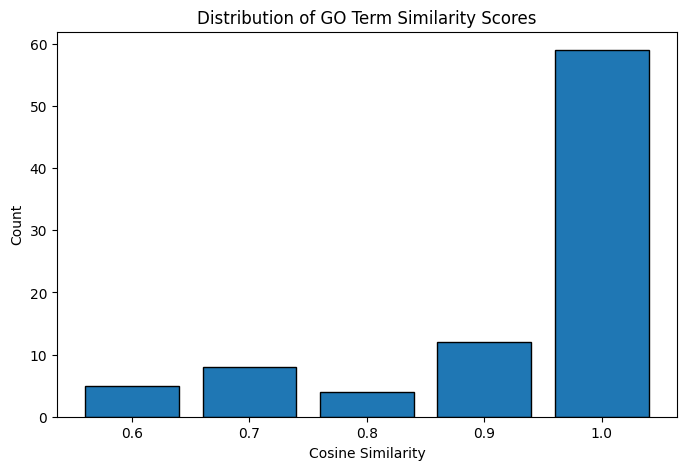

In [148]:
import matplotlib.pyplot as plt
from collections import Counter

# Suppose matched_terms is your dictionary of gene predictions (from auto_match_go_terms)
# where each value is a list of dictionaries with a key 'similarity'
similarity_scores = []
for gene, matches in matched_terms.items():
    for match in matches:
        similarity_scores.append(match['similarity'])

# Bin the similarity scores, e.g., rounded to one decimal place.
binned_scores = [round(score, 1) for score in similarity_scores]
score_counts = Counter(binned_scores)

# Prepare data for the bar plot.
bins = sorted(score_counts.keys())
counts = [score_counts[b] for b in bins]

plt.figure(figsize=(8, 5))
plt.bar(bins, counts, width=0.08, edgecolor='black')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.title('Distribution of GO Term Similarity Scores')
plt.xticks(bins)
plt.show()


## 6.2. Scoring against NCBI Gene database

Need to make a new scoring system: possibly True Positive (what we found), Nobel Positive (NP), Not Detected

- for cases where we have Go terms that are alike like "Wnt signaling pathway" and "canonical Wnt signaling pathway", we can embed the terms and check if they are similar. If they are, then we can consider them as the same term. If not, then we can consider them as different terms.

In [ ]:
# term = "Cul4A-RING E3 ubiquitin ligase complex"
# example_llama_term = "ubiquitin ligase complex"
# def compute_semantic_similarity(term1, term2, model):
#     """
#     Returns a cosine similarity score between two text strings, using
#     a SentenceTransformer model.
#     """
#     emb1 = model.encode(term1, convert_to_tensor=True)
#     emb2 = model.encode(term2, convert_to_tensor=True)
#     cos_sim = util.cos_sim(emb1, emb2)
#     return float(cos_sim[0][0])  # scalar

# # Compute the semantic similarity between the Llama term and the official GO term
# res = compute_semantic_similarity(example_llama_term, term, sapbert_model)
# print(f"Semantic similarity between '{example_llama_term}' and '{term}': {res:.2f}")

The code below takes a bit of time due to:
- api calls to retrieve the gene ontology terms from NCBI Gene database for each gene

In [ ]:
import json
from sentence_transformers import SentenceTransformer, util
from Bio import Entrez
import xml.etree.ElementTree as ET
import time
import requests

###############################################################################
# CONFIGURATION
###############################################################################
Entrez.email = "your_email@example.com"  # Use a valid email address

SIMILARITY_THRESHOLD = 0.68
MARGIN = 0.1  # The margin by which we'll allow a same-paper match to be "close enough"

# Define which evidence codes are considered experimental/curated.
experimental_codes = {"IDA", "IMP", "IPI", "IEP"}

###############################################################################
# 1) Utility: map from local "namespace" to NCBI's GO Category strings
###############################################################################
def map_namespace_to_ncbi_category(ns):
    if ns == "biological_process":
        return "Process"
    elif ns == "molecular_function":
        return "Function"
    elif ns == "cellular_component":
        return "Component"
    return None

###############################################################################
# 2) Fetch the GO annotations from NCBI Gene for a given gene_id
###############################################################################
def fetch_gene_go_terms(gene_id):
    """
    Fetch the NCBI Gene record (XML) for `gene_id` and parse out GO annotations.
    Returns a dict of lists, keyed by: "Function", "Process", "Component".
    """
    # Sleep to respect NCBI usage guidelines
    time.sleep(0.3)

    handle = Entrez.efetch(db="gene", id=gene_id, retmode="xml")
    xml_data = handle.read()
    handle.close()

    root = ET.fromstring(xml_data)
    go_annotations = {}

    for gene_commentary in root.findall(".//Gene-commentary"):
        heading_elem = gene_commentary.find("Gene-commentary_heading")
        if heading_elem is not None and heading_elem.text == "GeneOntology":
            for category_block in gene_commentary.findall(".//Gene-commentary_comment/Gene-commentary"):
                label_elem = category_block.find("Gene-commentary_label")
                if label_elem is None:
                    continue
                category_label = label_elem.text  # "Function", "Process", or "Component"

                if category_label not in go_annotations:
                    go_annotations[category_label] = []

                inner_comment = category_block.find("Gene-commentary_comment")
                if inner_comment is None:
                    continue

                for go_term_block in inner_comment.findall("Gene-commentary"):
                    dbtag_db = go_term_block.find(".//Dbtag_db")
                    if dbtag_db is not None and dbtag_db.text == "GO":
                        # Parse the GO ID
                        object_id_elem = go_term_block.find(".//Object-id_id")
                        if object_id_elem is not None:
                            numeric_id = object_id_elem.text
                            padded_id = numeric_id.zfill(7)
                            go_id = f"GO:{padded_id}"
                        else:
                            go_id = "GO:unknown"

                        # Parse the GO term name
                        anchor_elem = go_term_block.find(".//Other-source_anchor")
                        go_term_name = anchor_elem.text if anchor_elem is not None else "Unknown Term"

                        # Evidence code
                        evidence_code = None
                        post_text_elem = go_term_block.find(".//Other-source_post-text")
                        if post_text_elem is not None:
                            post_text_str = post_text_elem.text
                            if post_text_str and "evidence: " in post_text_str:
                                evidence_code = post_text_str.split("evidence:")[-1].strip()
                            else:
                                evidence_code = post_text_str

                        # PubMed IDs
                        pubmed_ids = []
                        refs_block = go_term_block.find("Gene-commentary_refs")
                        if refs_block is not None:
                            for pub in refs_block.findall("Pub"):
                                pmid_elem = pub.find(".//PubMedId")
                                if pmid_elem is not None:
                                    pubmed_ids.append(pmid_elem.text)

                        go_annotations[category_label].append({
                            "go_id": go_id,
                            "term": go_term_name,
                            "evidence": evidence_code,
                            "pubmed_ids": pubmed_ids
                        })

    return go_annotations

###############################################################################
# 3) Utility: compute cosine similarity using Sentence-BERT
###############################################################################
def compute_semantic_similarity(term1, term2, model):
    emb1 = model.encode(term1, convert_to_tensor=True)
    emb2 = model.encode(term2, convert_to_tensor=True)
    cos_sim = util.cos_sim(emb1, emb2)
    return float(cos_sim[0][0])

###############################################################################
# 4) Utility: convert a PMCID to PMID using NCBI E-utilities
###############################################################################
pmc_cache = {} # Cache for PMCID to PMID conversion

def pmcid_to_pmid(pmcid):
    """
    Convert a PMCID (e.g. 'PMC123456') to a numeric PMID string using NCBI E-utilities.
    Returns None if not found or conversion fails.
    """
    # cache since we dont want to hit the same PMCID multiple times
    if pmcid in pmc_cache:
        return pmc_cache[pmcid]
    
    base = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    url = base + f"esummary.fcgi?db=pmc&id={pmcid[3:]}&retmode=xml"
    # Note pmcid[3:] strips "PMC" prefix if we pass "PMC123456" to the 'id=' param

    resp = requests.get(url)
    if resp.status_code != 200:
        return None

    root = ET.fromstring(resp.text)

    for item in root.findall(".//Item"):
        if item.get("Name") == "pmid":
            pmid = item.text
            pmc_cache[pmcid] = pmid
            return pmid

    return None

def convert_local_pmcids_to_pmids(local_data):
    for gene_entry in local_data:
        for local_ann in gene_entry.get("go_data", []):
            refs = local_ann.get("reference(s)", [])
            new_refs = []
            for r in refs:
                # If r starts with 'PMC', attempt to convert
                if r.startswith("PMC"):
                    time.sleep(0.3)  # Respect NCBI usage guidelines
                    pmid = pmcid_to_pmid(r)
                    if pmid:
                        new_refs.append(pmid)
                    else:
                        # Conversion failed or none found, fallback
                        new_refs.append(r)
                else:
                    new_refs.append(r)
            local_ann["reference(s)"] = new_refs

###############################################################################
# 5) Main comparison & classification logic with tie-break margin
###############################################################################
def compare_json_vs_ncbi(json_path, model):
    """
    For each local annotation (term + references), we:
      1) Gather all possible NCBI annotations in the same GO category
      2) Find best match overall & best match among same-paper (i.e., shared PMIDs)
      3) If best_same_score >= best_overall_score - MARGIN, prefer the same-paper match
      4) Classify that chosen match as TP if it shares references, else DCU (if >= threshold),
         or NP if below threshold.
    """
    with open(json_path, "r") as f:
        local_data = json.load(f)

    # Convert PMCIDs in local_data to numeric PMIDs since NCBI uses PMIDs even thorugh GO annotations are curated from PMC
    convert_local_pmcids_to_pmids(local_data)

    all_comparisons = []

    for gene_entry in local_data:
        gene_name = gene_entry["gene"]
        gene_id = gene_entry["geneID"]
        local_go_data = gene_entry.get("go_data", [])

        print(f"\n=== Checking Gene: {gene_name} (ID={gene_id}) ===")

        ncbi_annotations = fetch_gene_go_terms(gene_id)

        # We'll keep track of official GO annotations (for ND detection)
        official_by_pmid = set()
        for category_label, ann_list in ncbi_annotations.items():
            for ann in ann_list:
                for pmid in ann["pubmed_ids"]:
                    official_by_pmid.add((category_label, ann["term"], pmid))

        matched_officials = set()
        comparisons_this_gene = []

        # Per-gene counters
        count_tp = 0
        count_np = 0
        count_dcu = 0

        #
        # 1) CLASSIFY EACH LOCAL ANNOTATION (TP, NP, DCU)
        #
        for local_ann in local_go_data:
            local_term = local_ann["term"]
            local_refs = set(local_ann.get("reference(s)", []))
            local_ns = local_ann.get("namespace", None)
            target_category = map_namespace_to_ncbi_category(local_ns)

            classification = None
            chosen_match_info = None
            chosen_score = -1.0

            best_score_all = -1.0
            best_info_all = None
            best_score_same = -1.0
            best_info_same = None

            if target_category and target_category in ncbi_annotations:
                possible_anns = ncbi_annotations[target_category]

                # (A) Find best match overall
                for ann in possible_anns:
                    sc = compute_semantic_similarity(local_term, ann["term"], model)
                    if sc > best_score_all:
                        best_score_all = sc
                        best_info_all = ann

                # (B) Find best match among same-paper
                same_paper_anns = [
                    ann for ann in possible_anns
                    if set(ann["pubmed_ids"]).intersection(local_refs)
                ]
                for ann in same_paper_anns:
                    sc = compute_semantic_similarity(local_term, ann["term"], model)
                    if sc > best_score_same:
                        best_score_same = sc
                        best_info_same = ann

                # (C) Tie-break
                if best_score_same >= 0:
                    # There's at least one same-paper annotation
                    if best_score_same >= best_score_all - MARGIN:
                        chosen_score = best_score_same
                        chosen_match_info = best_info_same
                    else:
                        chosen_score = best_score_all
                        chosen_match_info = best_info_all
                else:
                    chosen_score = best_score_all
                    chosen_match_info = best_info_all

                # (D) Classify
                if chosen_score >= SIMILARITY_THRESHOLD and chosen_match_info is not None:
                    overlap = set(chosen_match_info["pubmed_ids"]).intersection(local_refs)
                    if overlap:
                        classification = "TP"
                        count_tp += 1
                        # Mark the official annotation as matched
                        for pmid in chosen_match_info["pubmed_ids"]:
                            if pmid in local_refs:
                                matched_officials.add((target_category, chosen_match_info["term"], pmid))
                    else:
                        classification = "DCU"
                        count_dcu += 1
                else:
                    classification = "NP"
                    count_np += 1
            else:
                # No recognized category => NP
                classification = "NP"
                count_np += 1

            rec = {
                "gene": gene_name,
                "geneID": gene_id,
                "local_term": local_term,
                "namespace": local_ns,
                "references_used": list(local_refs),
                "classification": classification,
                "best_score": chosen_score,
            }
            if chosen_match_info:
                rec["best_ncbi_match"] = chosen_match_info["term"]
                rec["best_ncbi_go_id"] = chosen_match_info["go_id"]
                rec["best_ncbi_pubmed_ids"] = chosen_match_info["pubmed_ids"]
            else:
                rec["best_ncbi_match"] = None
                rec["best_ncbi_go_id"] = None
                rec["best_ncbi_pubmed_ids"] = []

            comparisons_this_gene.append(rec)

        #
        # 2) DETECT ND (NOT DETECTED) AND STORE AS ADDITIONAL RECORDS
        #
        # ND means: official NCBI annotation referencing the local paper(s),
        # but never matched as a TP above.
        #
        undetected = official_by_pmid - matched_officials

        # The local paper set is all refs mentioned in local_go_data
        all_local_pmids_for_gene = set()
        for ann in local_go_data:
            all_local_pmids_for_gene |= set(ann.get("reference(s)", []))

        actual_nd = []
        for (cat_label, term_text, pmid) in undetected:
            if pmid in all_local_pmids_for_gene:
                actual_nd.append((cat_label, term_text, pmid))

        count_nd = len(actual_nd)

        # Storing ND in comparisons_this_gene
        # For each official annotation that is ND, we add a new record
        for (cat_label, ncbi_term, pmid) in actual_nd:
            rec = {
                "gene": gene_name,
                "geneID": gene_id,
                "local_term": None,  # No local annotation matched
                "namespace": cat_label,
                "references_used": [pmid],  # or empty if you prefer
                "classification": "ND",
                "best_score": None,
                # We might store the official annotation in 'best_ncbi_match'
                "best_ncbi_match": ncbi_term,
                "best_ncbi_go_id": None,  # We didn't parse that here, but could
                "best_ncbi_pubmed_ids": [pmid],
            }
            comparisons_this_gene.append(rec)
        
         #
        # 3) ADDITIONAL: Look for any NCBI annotation that has experimental evidence
        #    and shares a PubMed ID with the local articles, but was not already
        #    matched as TP (or reported as ND).
        #
        extra_added = set()  # to avoid duplicates (using (namespace, go_id) as key)
        for category_label, ann_list in ncbi_annotations.items():
            for ann in ann_list:
                if (ann["evidence"] in experimental_codes and 
                    set(ann["pubmed_ids"]).intersection(all_local_pmids_for_gene)):
                    key = (category_label, ann["go_id"])
                    if key not in extra_added:
                        # We add this extra record only if it was not already included above
                        rec = {
                            "gene": gene_name,
                            "geneID": gene_id,
                            "local_term": None,
                            "namespace": category_label,
                            "references_used": list(set(ann["pubmed_ids"]).intersection(all_local_pmids_for_gene)),
                            "classification": "GO with experiment codes (NCBI)",
                            "best_score": None,
                            "best_ncbi_match": ann["term"],
                            "best_ncbi_go_id": ann["go_id"],
                            "best_ncbi_pubmed_ids": ann["pubmed_ids"],
                            "evidence": ann["evidence"]
                        }
                        comparisons_this_gene.append(rec)
                        extra_added.add(key)

        #
        # 3) PRINT RESULTS
       
        # Summaries
        tps_for_gene = [x for x in comparisons_this_gene if x["classification"] == "TP"]
        nps_for_gene = [x for x in comparisons_this_gene if x["classification"] == "NP"]
        dcus_for_gene = [x for x in comparisons_this_gene if x["classification"] == "DCU"]
        nds_for_gene = [x for x in comparisons_this_gene if x["classification"] == "ND"]

        print("\n-- TPs --")
        for item in tps_for_gene:
            print(f"LocalTerm='{item['local_term']}' | BestNCBI='{item['best_ncbi_match']}' "
                  f"| Score={item['best_score']:.2f} | PMIDs={item['references_used']}")

        print("\n-- NPs --")
        for item in nps_for_gene:
            print(f"LocalTerm='{item['local_term']}' | Score={item['best_score']}"
                  f"| PMIDs={item['references_used']}")

        print("\n-- DCUs --")
        for item in dcus_for_gene:
            print(f"LocalTerm='{item['local_term']}' | BestNCBI='{item['best_ncbi_match']}' "
                  f"(diff. references) | Score={item['best_score']} | PMIDs={item['references_used']}")

        print("\n-- ND --")
        for item in nds_for_gene:
            print(f"NCBITerm='{item['best_ncbi_match']}' | PMID={item['best_ncbi_pubmed_ids']}")

        exp_records = [x for x in comparisons_this_gene if x["classification"] == "GO with experiment codes (NCBI)"]
        if exp_records:
            print("\n-- GO with experiment codes (NCBI) --")
            for item in exp_records:
                print(f"NCBITerm='{item['best_ncbi_match']}' | Evidence={item['evidence']} | PMIDs={item['references_used']}")

        
        print(f"\n== Per-gene Summary for {gene_name} ({gene_id}) ==")
        print(f"TP = {count_tp}, NP = {count_np}, DCU = {count_dcu}, ND = {count_nd}, "
              f"GO with experiment codes (NCBI) = {len(exp_records)}")
        print("--------------------------------------------------------")

        all_comparisons.extend(comparisons_this_gene)

    return all_comparisons

###############################################################################
# 6) Example usage
###############################################################################
json_file_path = "./processed_inferences/processed_output_PMC6484421.json"

try:
    comparison_results = compare_json_vs_ncbi(json_file_path, sapbert_model)
except requests.HTTPError as e:
    print(f"HTTPError: {e.code} - {e.reason}")
    print("Please check the gene ID or ensure that the NCBI API is accessible.")

# Now each item in comparison_results has classification in {TP, NP, DCU, ND}

# You can also sum ND from the final list if you want a global ND count
tp_global = sum(1 for r in comparison_results if r["classification"] == "TP")
np_global = sum(1 for r in comparison_results if r["classification"] == "NP")
dcu_global = sum(1 for r in comparison_results if r["classification"] == "DCU")
nd_global = sum(1 for r in comparison_results if r["classification"] == "ND")
exp_global = sum(1 for r in comparison_results if r["classification"] == "GO with experiment codes (NCBI)")


print("\n=== Global Summary Across All Genes ===")
print(f"Total entries: {len(comparison_results)}")
print(f"TP = {tp_global}, NP = {np_global}, DCU = {dcu_global}, ND = {nd_global}, "
      f"GO with experiment codes (NCBI) = {exp_global}")



=== Checking Gene: TGFBR3 (ID=7049) ===

-- TPs --

-- NPs --
LocalTerm='regulation of fibroblast proliferation' | Score=0.4910426437854767| PMIDs=['30729664']
LocalTerm='apoptotic process' | Score=0.4449974000453949| PMIDs=['30729664']

-- DCUs --
LocalTerm='transforming growth factor beta receptor activity' | BestNCBI='transforming growth factor beta receptor activity' (diff. references) | Score=0.9999999403953552 | PMIDs=['30729664']
LocalTerm='negative regulation of transforming growth factor beta receptor signaling pathway' | BestNCBI='negative regulation of transforming growth factor beta receptor signaling pathway' (diff. references) | Score=1.0 | PMIDs=['30729664']
LocalTerm='cell surface' | BestNCBI='cell surface' (diff. references) | Score=1.0000001192092896 | PMIDs=['30729664']

-- ND --
NCBITerm='negative regulation of extracellular matrix assembly' | PMID=['30729664']
NCBITerm='negative regulation of SMAD protein signal transduction' | PMID=['30729664']
NCBITerm='positive

Will put TP, ND, DCU and NP in a excel file in the output folder
change the sheet_name to the name of the file you want to save it as in the excel. After that, open excel and copy the sheet to the main sheet. Then delete the other sheet.

In [139]:
import pandas as pd
import os
from openpyxl import load_workbook
from collections import defaultdict

###############################################################################
# 1) Aggregate classification_counts from comparison_results
###############################################################################
classification_counts = defaultdict(lambda: {"TP": 0, "NP": 0, "DCU": 0, "ND": 0})

for row in comparison_results:
    gene_id = row["geneID"]
    gene_name = row["gene"]
    classification = row["classification"]
    
    # For each PMID in references_used, increment the classification count
    for pmid in row["references_used"]:
        key = (gene_id, gene_name, pmid)
        classification_counts[key][classification] += 1

records_for_df = []
for (gid, gname, pmid), counts in classification_counts.items():
    records_for_df.append({
        "geneID": gid,
        "gene": gname,
        "pmid": pmid,
        "TP": counts["TP"],
        "ND": counts["ND"],
        "NP": counts["NP"],
        "DCU": counts["DCU"]
    })

df = pd.DataFrame(
    records_for_df,
    columns=["geneID", "gene", "pmid", "TP", "ND", "NP", "DCU"]
)

###############################################################################
# 2) Write to Excel, appending a NEW SHEET for each paper
###############################################################################
output_path = r"/Users/crystalcho/Downloads/Evaluation.xlsx"

# You can change this to something unique for each paper you analyze.
sheet_name = "PMC6742646"

# If the file already exists, open in append mode. Otherwise, create a new file.
mode = "a" if os.path.exists(output_path) else "w"

if mode == "w":
    # Create a new file and write data
    df.to_excel(output_path, sheet_name=sheet_name, index=False)
else:
    # If the file already exists, append a new sheet
    with pd.ExcelWriter(output_path, engine="openpyxl", mode="a", if_sheet_exists="new") as writer:
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Finished! Data written to sheet '{sheet_name}' in file: {output_path}")


Finished! Data written to sheet 'PMC6742646' in file: /Users/crystalcho/Downloads/Evaluation.xlsx
